In [1]:
!which python
!python --version

/Users/swagatam/miniconda3/envs/datalit/bin/python
Python 3.10.13


In [2]:
import os, re, json, requests
import PyPDF2
import urllib.request
from bs4 import BeautifulSoup
from scipy import stats


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys; sys.path.append('../')  # to import src

In [3]:
from src import maps

pd.set_option('display.max_columns', 100)
# plt.style.use('ggplot')

In [4]:
DATA_DIR = os.path.join('..', 'dat')
!ls $DATA_DIR;
!tree $DATA_DIR/

2021
../dat/
└── 2021
    ├── cpsnov21.pdf
    ├── nov21pub.csv
    └── nov21pub.dat

2 directories, 3 files


In [5]:
year = '2021'
CSV_FILE_PATH = os.path.join(DATA_DIR, os.path.join(year, f'nov{year[2:]}pub.csv'))
CSV_FILE_PATH

'../dat/2021/nov21pub.csv'

## Some important attributes

In [6]:
PERSONTYPE = 'PRPERTYP'
SEX = 'PESEX'
AGE = 'PRTAGE'
STATECODE = 'GESTFIPS'
SOCIALMEDIA = 'PESOCIAL'
TEXTING = 'PETEXTIM'
EMAIL = 'PEEMAIL'

# During the past year, (have you/has any member of your household) been affected by an
# online security breach, identity theft, or a similar crime?
CYBERCRIME='HEPSCYBA'


#what concerns (you/members of this household) the most when it comes to online privacy and security risks?
CONCERNS_MAP = {
    'HEPSCON1': 'Identity theft',
    'HEPSCON2': 'Credit card or banking fraud',
    'HEPSCON3': 'Data collection or tracking by online services',
    'HEPSCON4': 'Data collection or tracking by government',
    'HEPSCON5': 'Loss of control over personal data such as email or social network profiles',
    'HEPSCON6': 'Threats to personal safety, such as online harassment, stalking, or cyberbullying',
    'HEPSCON8': 'Other concerns'
}

# During the past year, have concerns about privacy or security STOPPED (you/anyone in this household)
# from doing any of these activities online
ACTIVITIES_MAP = {
    'HEPSPRE1': 'Conducting financial transactions such as banking, investing, or paying bills online?',
    'HEPSPRE2': 'Buying goods or services online?',
    'HEPSPRE3': 'Posting photos, status updates, or other information on social networks?',
    'HEPSPRE4': 'Expressing an opinion on a controversial or political issue on a blog or social network, or in a forum, email or any other venue?',
    'HEPSPRE5': 'Searching for information using a platform such as Google Search, Yahoo Search, Microsoft Bing, or another web search engine?'
}

CONCERNS = list(CONCERNS_MAP.keys())
ACTIVITIES = list(ACTIVITIES_MAP.keys())


DROP_COLUMNS = [
    'FILLER',  # all rows have NaN values for some reason
]

In [7]:
df21 = pd.read_csv(CSV_FILE_PATH)
df21 = df21[(df21[AGE] >= 10) * (df21[SEX] != -1)]
df21 = df21.drop(DROP_COLUMNS, axis=1)

columns = features = df21.columns.to_list()

In [8]:
print(f'# Rows = {len(df21)}\n# Columns = {df21.shape[1]}')
print(f'unique dtypes present: {df21.dtypes.unique()}')

# Rows = 90941
# Columns = 567
unique dtypes present: [dtype('int64')]


## Inspect our target variables of interest

The following query strings show two subsets of the data where we have atleast one yes ($1$) for the **concern** (on using the internet in general), and **activity** (specific things that people hesitate to do on the digital space) variables. In the data these variables also have a value of $-1$ that we are filtering out since it has ambiguous interpretation: either it was not possible to collect the survey response, or the person did not respond, or missing for some other reason.

Even after removing such rows, we see we have $24, 626\;(27.07\%)$ people expressing atleast one activity that they feel anxious to do, and $55, 588\;(61.12\%)$ people expressing some kind of concern about the digital realm.

In [9]:
query_string1 = ' or '.join([f'{item} == 1' for item in [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]]]) #concerns
query_string2 = ' or '.join([f'{item} == 1' for item in [f'HEPSPRE{i}' for i in [1,2,3,4,5]]])     #activities

In [10]:
dc = df21.query(query_string1)[CONCERNS_MAP.keys()]
print(f'# any -1: {(dc == -1).sum().sum()}')
dc.head()

# any -1: 0


,HEPSCON1,HEPSCON2,HEPSCON3,HEPSCON4,HEPSCON5,HEPSCON6,HEPSCON8
5,1,1,1,1,2,2,2
6,1,1,2,2,2,2,2
7,1,1,2,2,2,2,2
8,1,1,2,2,2,2,2
9,1,1,2,2,2,2,2


In [11]:
da = df21.query(query_string2)[ACTIVITIES_MAP.keys()]
print(f'# any -1: {(da == -1).sum().sum()}')
da.head()

# any -1: 0


,HEPSPRE1,HEPSPRE2,HEPSPRE3,HEPSPRE4,HEPSPRE5
6,1,1,2,2,2
7,1,1,2,2,2
8,1,1,2,2,2
9,1,1,2,2,2
18,1,2,2,2,2


In [12]:
print(f'Expressed some concern: {dc.shape[0]} = {100*dc.shape[0]/df21.shape[0]:.2f}%')
print(f'Hesitates to do atleast one thing: {da.shape[0]} = {100*da.shape[0]/df21.shape[0]:.2f}%')

Expressed some concern: 55588 = 61.13%
Hesitates to do atleast one thing: 24626 = 27.08%


Another variable of interest is `HEPSCYBA` that asks: "during the past year, (have you/has any member of your household) been affected by an online security breach, identity theft, or a similar crime?", and we see $14,328$ people responding "Yes" to this.

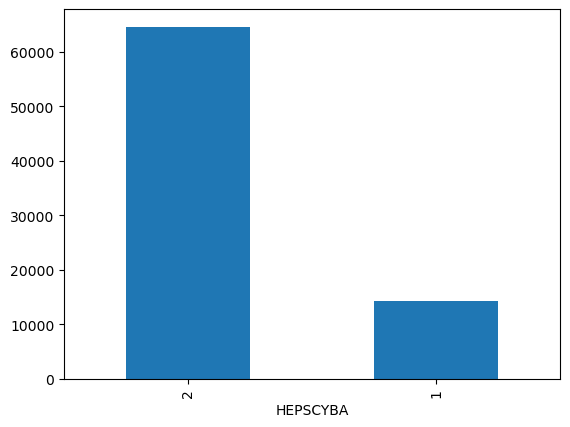

In [16]:
df21.query('HEPSCYBA != -1')[CYBERCRIME].value_counts().plot(kind='bar')
plt.show()

## Prepare some other maps

In [17]:
columnsmapa= {
    'HEPSPRE1': 'Financial transactions',
    'HEPSPRE2': 'Online shopping',
    'HEPSPRE3': 'Posting photos, status updates',
    'HEPSPRE4': 'Expressing controversial opinions',
    'HEPSPRE5': 'Searching on google, yahoo, bing'
}

columnsmapc = {
    'HEPSCON1': 'Identity theft',
    'HEPSCON2': 'Credit card fraus',
    'HEPSCON3': 'Data tracking',
    'HEPSCON4': 'Govt. data collection',
    'HEPSCON5': 'Losing digital credentials',
    'HEPSCON6': 'Cyber harrassment',
    'HEPSCON8': 'Other'
}

# poverty guidelines: https://aspe.hhs.gov/2021-poverty-guidelines
income_groups = {
    "below 35k": [1,2,3,4,5,6,7,8,9],
    "35k-60k": [10,11,12], #13],
    "60k-100k": [13, 14],
    "100k-150k": [15],
    "above 150k": [16]
}

age_groups = {
    '10-18':    [10, 18],
    '18-25':    [18, 25],
    '26-35':    [26, 35],
    '36-45':    [36, 45],
    '46-55':    [46, 55],
    '56-65':    [56, 65],
    '66+':      [66, 120],
}

education_groups = maps.educ  # education_educationid_mapping
industry_groups = maps.ind    # industry_jobid_mapping

In [18]:
education_groups, industry_groups

({'LTHS': [31, 32, 33, 34, 35, 36, 37, 38],
  'HS': [39],
  'SC': [40, 41, 42],
  'COLL': [43],
  'ADV': [44, 45, 46]},
 {'Construction and mining': [1, 2, 3],
  'Finance and business services': [7, 8, 9, 12],
  'Manufacturing': [4],
  'Trade, transportation, and utilities': [5, 6],
  'Education and health': [10],
  'Leisure and hospitality': [11],
  'Public administration': [13],
  'Armed forces': [14]})

## stratify and see proportions

In [34]:
def stratified_proportions(df,
                           stratify_by,      # age, income, education or job industry
                           categories_dict,  # mapping of age groups etc. as shown above
                           target_variables, # list of concerns/activities
                          ):
    
    # for each group, stores the probability of responding "YES" for each target variable
    stratified_output_count_normalized = {}
    sample_sizes = {}
    
    
    v = stratify_by
    for groupname, groupids in categories_dict.items():
        query_string = ' or '.join([f'{v} == {gid}' for gid in groupids])
        # print(groupname)
        _df = df.query(query_string)[target_variables]
        
        props = []  # props[i] = proportion for target variable i
        sample_size = []
        for tv in target_variables:
            # Take 1 target variable and find the proportion of people who responded as 1 (yes)
            _df1 = _df[[tv]]
            _df1 = _df1[_df1[tv] != -1]  # remove the -1 responses (only keep 1 or 2)
#             print(f'total #samples in this group for {tv} (Yes/No) = {_df1.shape[0]}')
#             print(f'yes: {_df1.value_counts()[1]}, no: {_df1.value_counts()[2]}; proportion: {_df1.value_counts(normalize=True)[1]:.4f}')
            props.append(_df1.value_counts(normalize=True)[1])
            sample_size.append(_df1.shape[0])
        
        stratified_output_count_normalized[groupname] = props
        sample_sizes[groupname] = sample_size
        
    return stratified_output_count_normalized, sample_sizes

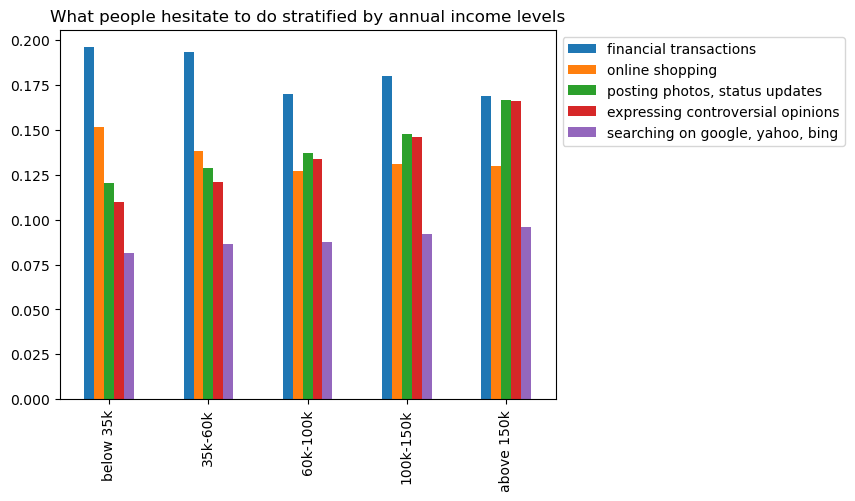

In [35]:
# call
res, sample_sizes = stratified_proportions(df21, stratify_by='HEFAMINC',
                             categories_dict=income_groups,
                             target_variables=ACTIVITIES)

df = pd.DataFrame.from_dict(res, orient='index')
# df = df[[3]]
df = df.rename(columns= {
    0: 'financial transactions',
    1: 'online shopping',
    2: 'posting photos, status updates',
    3: 'expressing controversial opinions',
    4: 'searching on google, yahoo, bing'
})



# Plot the DataFrame
ax = df.plot(kind='bar')
ax.set_title("What people hesitate to do stratified by annual income levels", color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

# Show the plot
plt.show()

In [36]:
df

,financial transactions,online shopping,"posting photos, status updates",expressing controversial opinions,"searching on google, yahoo, bing"
below 35k,0.195754,0.151253,0.120127,0.109752,0.081204
35k-60k,0.193156,0.138111,0.128936,0.120754,0.086474
60k-100k,0.169695,0.127157,0.136954,0.133807,0.087766
100k-150k,0.179761,0.131181,0.147401,0.145818,0.092017
above 150k,0.168625,0.129533,0.166377,0.166014,0.096098


In [37]:
sample_sizes

{'below 35k': [16674, 16674, 16674, 16674, 16674],
 '35k-60k': [16132, 16132, 16132, 16132, 16132],
 '60k-100k': [19700, 19700, 19700, 19700, 19700],
 '100k-150k': [12639, 12639, 12639, 12639, 12639],
 'above 150k': [13788, 13788, 13788, 13788, 13788]}

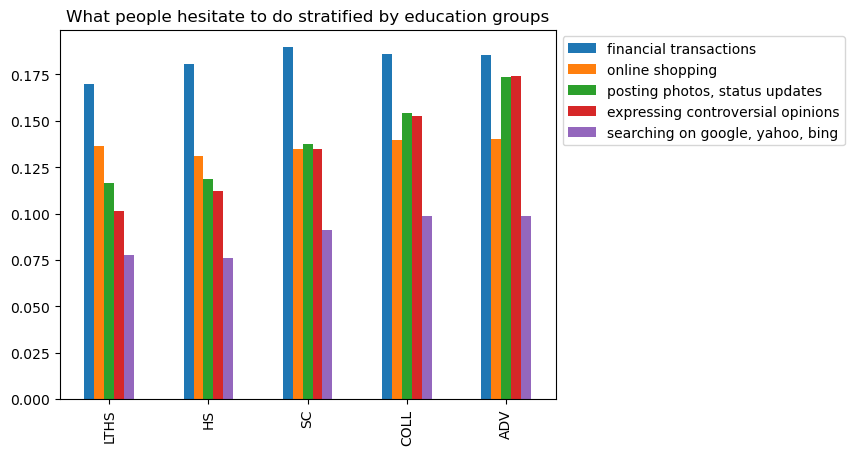

In [38]:
# call
res, sample_sizes = stratified_proportions(df21, stratify_by='PEEDUCA',
                             categories_dict=education_groups,
                             target_variables=ACTIVITIES)

df = pd.DataFrame.from_dict(res, orient='index')
# df = df[[3]]
df = df.rename(columns= {
    0: 'financial transactions',
    1: 'online shopping',
    2: 'posting photos, status updates',
    3: 'expressing controversial opinions',
    4: 'searching on google, yahoo, bing'
})



# Plot the DataFrame
ax = df.plot(kind='bar')
ax.set_title("What people hesitate to do stratified by education groups", color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

# Show the plot
plt.show()

In [39]:
sample_sizes

{'LTHS': [8397, 8397, 8397, 8397, 8397],
 'HS': [19580, 19580, 19580, 19580, 19580],
 'SC': [19248, 19248, 19248, 19248, 19248],
 'COLL': [16105, 16105, 16105, 16105, 16105],
 'ADV': [9794, 9794, 9794, 9794, 9794]}

## Chi-square test

We have seen that we have a **bianry** response variable `HEPSPRE4`, which asks people if they feel safe while
expressing _controversial_ opinions on the internet. And above, we observed that when the population is
split into 5 categories according to their annual family income levels (groups determined by consulting 2021
[US poverty guidelines](https://aspe.hhs.gov/2021-poverty-guidelines)), the fraction of the people who respond
"YES" to that question (`HEPSPRE4`) seems to show an increasing trend with income. Here, we want to test if
there is a suggestion/evidence of an association between the two variables: the binary response variable
`HEPSPRE4` and the categorical income level variable.

Since both variables are categorical, we consider doing a _chi-square test_ to test the null hypothesis that
there is no overall difference between people from different income levels with respect to how safe they feel
while expressing something controversial on the internet. To perform the test, we first construct the
5 x 2 contingency table (5 income groups, 2 response outcomes) for the two variables, and compute the expected
counts under the null hypothesis, that is simply the `(row total * column total) / total sample size` for a
(row, column) position in the contingency table.

Once we obtain the two tables (observed and expected counts), we compute the chi-square statistic and
obtain the p-value to test the significance.


References:
---
[1] [Chi-Square Test for Independence](https://online.stat.psu.edu/stat500/book/export/html/477)

[2] [Chi-square test for multiple categories](https://web.pdx.edu/~newsomj/pa551/lectur11.htm)

[3] [Concepts & Applications of Inferential Statistics, Chi-Square Procedures for Two Dimensions of Categorization](http://vassarstats.net/textbook/index.html)

In [40]:
v = 'HEFAMINC'
categories_dict = income_groups
opinion_variable = 'HEPSPRE4'  # expressing controversial opinions
financial_variable = 'HEPSPRE1'  # expressing controversial opinions

target_variable = opinion_variable

arr = []
for groupname, groupids in categories_dict.items():
    query_string = ' or '.join([f'{v} == {gid}' for gid in groupids])
    print(groupname, query_string)
    
    _df = df21.query(query_string)[[target_variable]]
    _df = _df[_df[target_variable] != -1]  # remove the -1 responses (only keep 1 or 2)
    print(_df.shape)
    print(f'proportion: {_df.value_counts(normalize=True)[1]:.4f}')
    print(f'yes: {_df.value_counts()[1]}, no: {_df.value_counts()[2]}')
    arr.append([_df.value_counts()[1], _df.value_counts()[2], len(_df)])
    print('----')

below 35k HEFAMINC == 1 or HEFAMINC == 2 or HEFAMINC == 3 or HEFAMINC == 4 or HEFAMINC == 5 or HEFAMINC == 6 or HEFAMINC == 7 or HEFAMINC == 8 or HEFAMINC == 9
(16674, 1)
proportion: 0.1098
yes: 1830, no: 14844
----
35k-60k HEFAMINC == 10 or HEFAMINC == 11 or HEFAMINC == 12
(16132, 1)
proportion: 0.1208
yes: 1948, no: 14184
----
60k-100k HEFAMINC == 13 or HEFAMINC == 14
(19700, 1)
proportion: 0.1338
yes: 2636, no: 17064
----
100k-150k HEFAMINC == 15
(12639, 1)
proportion: 0.1458
yes: 1843, no: 10796
----
above 150k HEFAMINC == 16
(13788, 1)
proportion: 0.1660
yes: 2289, no: 11499
----


In [43]:
arr = np.array(arr)
do = pd.DataFrame(arr, columns=['Yes', 'No', 'Total (rows)'])
do.index = categories_dict.keys()
do.loc['Total (cols)'] = do.sum(0)
do

,Yes,No,Total (rows)
below 35k,1830,14844,16674
35k-60k,1948,14184,16132
60k-100k,2636,17064,19700
100k-150k,1843,10796,12639
above 150k,2289,11499,13788
Total (cols),10546,68387,78933


In [44]:
observed_table = do.iloc[0:len(categories_dict), :2]
observed_table

,Yes,No
below 35k,1830,14844
35k-60k,1948,14184
60k-100k,2636,17064
100k-150k,1843,10796
above 150k,2289,11499


In [45]:
# expected counts under null hypothesis
# https://online.stat.psu.edu/stat500/book/export/html/477
expected_table = (observed_table.sum(1).values[:, None] * observed_table.sum(0).values[None, :]) / observed_table.values.sum()
expected_table

array([[ 2227.76283684, 14446.23716316],
       [ 2155.34785198, 13976.65214802],
       [ 2632.05756781, 17067.94243219],
       [ 1688.65865988, 10950.34134012],
       [ 1842.1730835 , 11945.8269165 ]])

In [49]:
r, c = observed_table.shape
dof = (r-1)*(c-1)

# compute test statistic manually
chi2 = ((observed_table.values.flatten() - expected_table.flatten())**2 / (expected_table.flatten())).sum()
chi2

246.37695704437385

In [52]:
from scipy.stats import chisquare
chisquare(f_obs=observed_table.values.flatten(), f_exp=expected_table.flatten(), ddof=dof)

Power_divergenceResult(statistic=246.37695704437385, pvalue=3.2916968758376956e-51)